# Maximum Likelihood Method Evaluation

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

from bgspy.utils import get_files, load_pickle, rel_error, abs_error, latex_scientific_notation
from bgspy.optim import optim_diagnotics_plot

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [4]:
from bgspy.likelihood import negll_simplex

def neutral_params(nt, nf, pi0, mu):
    W = np.zeros((nt, nf))
    #W[0, :] = 1  # all neutral
    theta = np.empty(2 + nt*nf)
    theta[0] = pi0
    theta[1] = mu
    theta[2:] = W.flat
    return theta

def null_negloglik(fit):
    Y = fit.Y
    nS, nD = Y.T
    pi0 = nD.sum() / (nS.sum()+nD.sum())
    log_pi = np.log(pi0)
    ll = np.sum(nD*log_pi + nS*np.log1p(-np.exp(log_pi)))
    return -ll

def lik_ratio(fit):
    ll_full = -fit.nll_
    ll_reduced = -null_negloglik(fit)
    LR = -2 * (ll_reduced - ll_full)
    return LR


/home/vsb/projects/bprime/bgspy/data.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


## Load Data

In [5]:
DIR_default = '../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed__demography/mle/default/1000000/N__1000/synthetic__chr1_chr2_chr3_chr4_chr5/'
DIR_full = '../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed__demography/mle/full/1000000/N__1000/synthetic__chr1_chr2_chr3_chr4_chr5//'
mles = get_files(DIR_default, '_mle.pkl') + get_files(DIR_full, '_mle.pkl')

In [6]:
from copy import copy
import warnings
from tqdm import tqdm
import os

def merge_chrom_metadata(md, ignore=('chrom', 'chrom_length', 'subs', 'dfe', 'recmap_file', 'seqlens_file', 'sim_tree_file')):
    """
    The simulation trees come in with *a lot* of metadata. This is all in a dictionary
    per-individul-sim, but each MLE fit is on a synthetic chromosome. So this checks
    that all metadata not in ignore (i.e. will be unique per sim ) is the same.
    and outputs it.
    """
    params = []
    def unpack(x):
        if isinstance(x, list) and len(x) == 1:
            return x[0]
        return x
    # the Bs file is packaged with the chromosome metedata, extract it first
    bs_file = md.pop('bs_file')
    for chrom, dat in md.items():
        row = {k: unpack(dat[k]) for k in dat.keys() if k not in ignore}
        if len(params):
            assert list(row.values()) == list(params[-1].values()), (row, params[-1])
        params.append(row)
    md = params[-1]
    md['bs_file'] = bs_file
    return md


def read_fixed_sh_sim_fits(mle_files):
    rows = []
    for fit_file in tqdm(mle_files):
        fits = load_pickle(fit_file)
        mb, mbp = fits['mb'], fits['mbp']
        mb_md = merge_chrom_metadata(mb.metadata)
        mbp_md = merge_chrom_metadata(mbp.metadata)        
        assert mb_md == mbp_md, "B and B' having differing metadata!"
        row = dict(mbp_md)
        # now get the fits for each chromosome
        for model, model_fit in fits.items():
            LR = lik_ratio(model_fit)
            row = copy(row)
            theta = model_fit.param_dict()
            row['model'] = model
            row['LR'] = LR
            row[f'est_mu'] = model_fit.mle_mu
            row[f'est_pi0'] = model_fit.mle_pi0
            sim_sh = int(np.round(np.log10(row['sh']), 8))
            W = np.array(model_fit.mle_W)
            with np.errstate(under='ignore'):
                row['R2'] = model_fit.R2()
                row['est_mean_sh'] = np.average(model_fit.t, weights=W[:, 0])
            row['features'] = '-'.join(model_fit.features)
            row['sh_rel_error'] = rel_error(row['est_mean_sh'], row['sh'], as_percent=False)
            row['fit'] = model_fit
            row['negll'] = model_fit.nll_
            rows.append(row)
    return pd.DataFrame(rows)


d = read_fixed_sh_sim_fits(mles)
d['track_type'] = [dict(default='sparse track', full='full track')[x.replace('bmap__', '').replace('.pkl', '')] for x in d['bs_file']]
model_labels = dict(mb='classic B', mbp="new B'")
d['type'] = [f"{track}, {model_labels[model]}, {exp}" for track, model, exp in zip(d['track_type'], d['model'], d['exp_rate'])]
d['log10_sh'] = np.log10(d['sh'])
d['log10_est_mean_sh'] = np.log10(d['est_mean_sh'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:16<00:00, 66.86it/s]


In [7]:
dg = d.groupby(['sim_mu', 'N', 'annot_file', 'h', 'mu', 'name', 'sh', 'bs_file', 'features', 'track_type', 'type', 'model']).mean().reset_index()

/tmp/ipykernel_17974/746880589.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dg = d.groupby(['sim_mu', 'N', 'annot_file', 'h', 'mu', 'name', 'sh', 'bs_file', 'features', 'track_type', 'type', 'model']).mean().reset_index()


In [8]:
dg['sh_rel_error'] = [rel_error(est, real, as_percent=False) for est, real in zip(dg['est_mean_sh'], dg['sh'])]
dg['sh_abs_error'] = [abs_error(est, real) for est, real in zip(dg['est_mean_sh'], dg['sh'])]
dg['bias'] = [(est-real) for est, real in zip(dg['est_mean_sh'], dg['sh'])]

In [9]:
dg.tail()

,sim_mu,N,annot_file,h,mu,name,sh,bs_file,features,track_type,...,est_mu,est_pi0,R2,est_mean_sh,sh_rel_error,negll,log10_sh,log10_est_mean_sh,sh_abs_error,bias
219,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__default.pkl,merged,sparse track,...,1.451425e-08,0.000940,0.320390,0.039340,0.213198,1.862783e+12,-1.30103,-1.416704,0.010660,-0.010660
220,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__full.pkl,merged-other,full track,...,1.000000e-09,0.001200,0.194712,0.005768,0.884640,2.307798e+12,-1.30103,-2.267911,0.044232,-0.044232
221,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__full.pkl,merged-other,full track,...,1.000000e-09,0.000941,0.174298,0.004819,0.903615,1.863121e+12,-1.30103,-2.369823,0.045181,-0.045181
222,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__full.pkl,merged-other,full track,...,1.197098e-08,0.001161,0.347786,0.036854,0.262925,2.306849e+12,-1.30103,-1.449225,0.013146,-0.013146
223,2.500000e-07,1000,../../data/annotation/conserved_cds_utrs_phast...,0.5,1.500000e-08,conserved_cds_utrs_phastcons_merged__hapmap__f...,0.05,bmap__full.pkl,merged-other,full track,...,1.453989e-08,0.000937,0.318360,0.038412,0.231768,1.862215e+12,-1.30103,-1.426021,0.011588,-0.011588


## Evaluation of Fixed-Selection Coefficient Simulations and MLE fits

### Constant Population size, Additive Effects

/tmp/ipykernel_17974/3099143333.py:59: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = old_legend.legendHandles


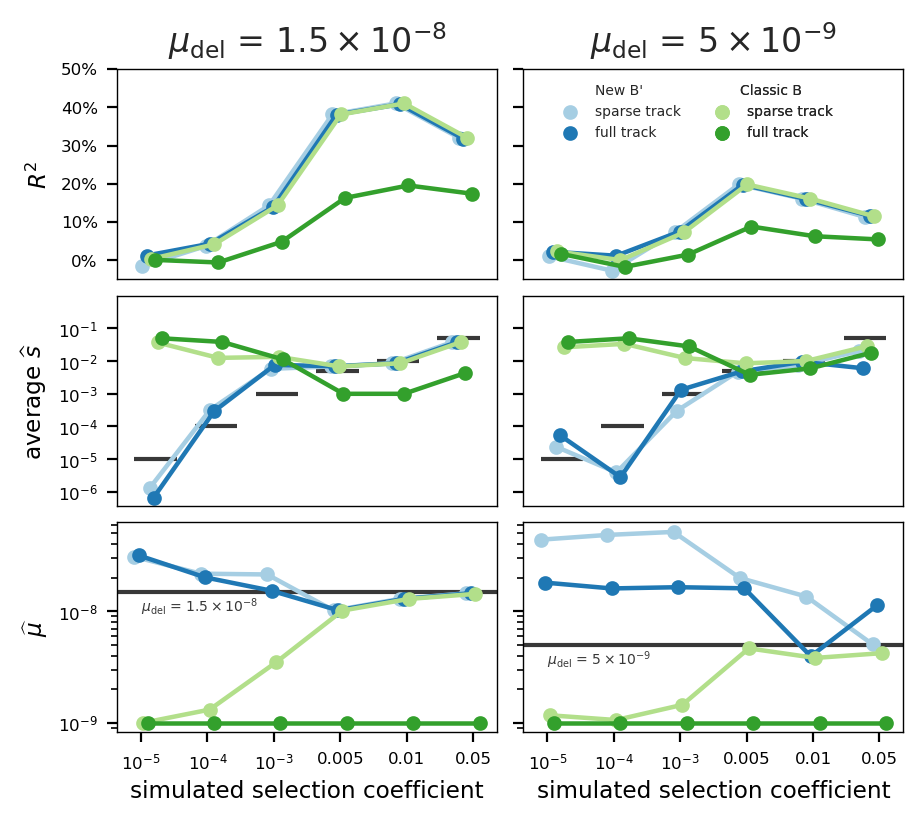

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharey='row', figsize=(4.5, 4), layout='constrained')

# Define common variables
order = ["sparse track, new B', False",
         "full track, new B', False",
         "sparse track, classic B, False",
         "full track, classic B, False",]
color_palette = sns.color_palette("Paired", len(order))
xx = np.arange(6)
xtick_labels = ["$10^{-5}$", "$10^{-4}$", "$10^{-3}$", "0.005", "0.01", "0.05"]
for col, mu_value, y_label in zip(range(2), [1.5e-8, 0.5e-8], ['1.5e-8', '0.5e-8']):
    df = d.loc[(d['exp_rate'] == False) & (d['mu'] == mu_value) & (d['sh'] > 1e-8) & (d['h'] == 0.5)].sort_values(['type', 'model'])

    # Loop through rows
    for row, plot_y, ylabel in zip(range(3), ['R2', 'log10_est_mean_sh', 'est_mu'], ['$R^2$', 'average $\widehat{s}$', '$\widehat{\mu}$']):
        fax = ax[row, col]
        sns.pointplot(x='sh', y=plot_y, data=df, hue='type', ax=fax, hue_order=order, errorbar=None, scale=0.6,
                      dodge=0.2, palette=color_palette)
        fax.legend_.remove()
        mulab = latex_scientific_notation(mu_value)
        if row == 0:
            r2_ticks = np.arange(0, 0.51, 0.1)
            fax.set_yticks(r2_ticks)
            fax.set_yticklabels([f'{tick * 100:.0f}%' for tick in r2_ticks], fontsize=6)
            fax.set_title(f"$\mu_\\mathrm{{del}}$ = {mulab}")
        elif row == 1:
            ylabs = np.array([-6, -5, -4, -3, -2, -1 ])
            fax.set_yticks(ylabs)
            fax.set_yticklabels([f'$10^{{{tick}}}$' for tick in ylabs], fontsize=6)
            true_sh = [np.log10(float(x.get_text())) for x in fax.get_xticklabels()]
            x_positions = np.arange(len(true_sh))
            fax.hlines(true_sh, x_positions - 0.35, x_positions + 0.35, color='0.22', linewidth=1.5, zorder=-1)
            fax.set_ylim(None, 0.001)
        elif row == 2:
            fax.axhline(mu_value, c='0.22', linestyle='solid', linewidth=1.5, zorder=-1)
            fax.annotate(f"$\mu_\\mathrm{{del}}$ = {mulab}", (0, 0.66*mu_value), fontsize=5, c='0.22')
            fax.semilogy()
            fax.tick_params(labelsize=6)
            
        if row != 2:
            fax.set_xticks([])
            fax.set_xticklabels([])
            fax.set_xlabel('')
        else:
            fax.set_xticks(xx)
            fax.set_xticklabels(xtick_labels, fontsize=6)
            fax.set_xlabel('simulated selection coefficient')

        if col == 1:
            ylabel = ''
    
        fax.set_ylabel(ylabel)
        
lax = ax[0, 1]
old_legend = lax.legend()
lax.legend_.remove()

# Get the legend components
legend_handles = old_legend.legendHandles
legend_labels = [t.get_text().split(',')[0] for t in old_legend.get_texts()]

# Split the components into two lists
midpoint = len(legend_handles) // 2
legend_handles_1 = legend_handles[:midpoint]
legend_labels_1 = legend_labels[:midpoint]
legend_handles_2 = legend_handles[midpoint:]
legend_labels_2 = legend_labels[midpoint:]

# Create two separate legends using the lists
font_kwargs = dict(fontsize=5, title_fontsize=5)
legend_1 = lax.legend(legend_handles_1, legend_labels_1, loc=(0.05, 0.6), title="New B'", **font_kwargs)
legend_2 = lax.legend(legend_handles_2, legend_labels_2, loc=(0.45, 0.6),  title="Classic B", **font_kwargs)
lax.add_artist(legend_1)
lax.add_artist(legend_2)
# Add the legends to the plot
#fig.legend(loc=(0.9, 0.5), handles=legend_handles_1, labels=legend_labels_1, fontsize=5, title='New B\'', title_fontsize=7)
#fig.legend(loc=(0.9, 0.6), handles=legend_handles_2, labels=legend_labels_2, fontsize=5, title="Classic B", title_fontsize=7)


#plt.tight_layout()
plt.savefig('../manuscript/figures/subfigure_sim_mle.pdf', bbox_inches='tight')

NOTE: the y-axis here is the average selection coefficient, taken by $\bar{s} = \sum_i W_i s$

### Demographic Expansion

/tmp/ipykernel_17974/161449793.py:59: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = old_legend.legendHandles
/tmp/ipykernel_17974/161449793.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


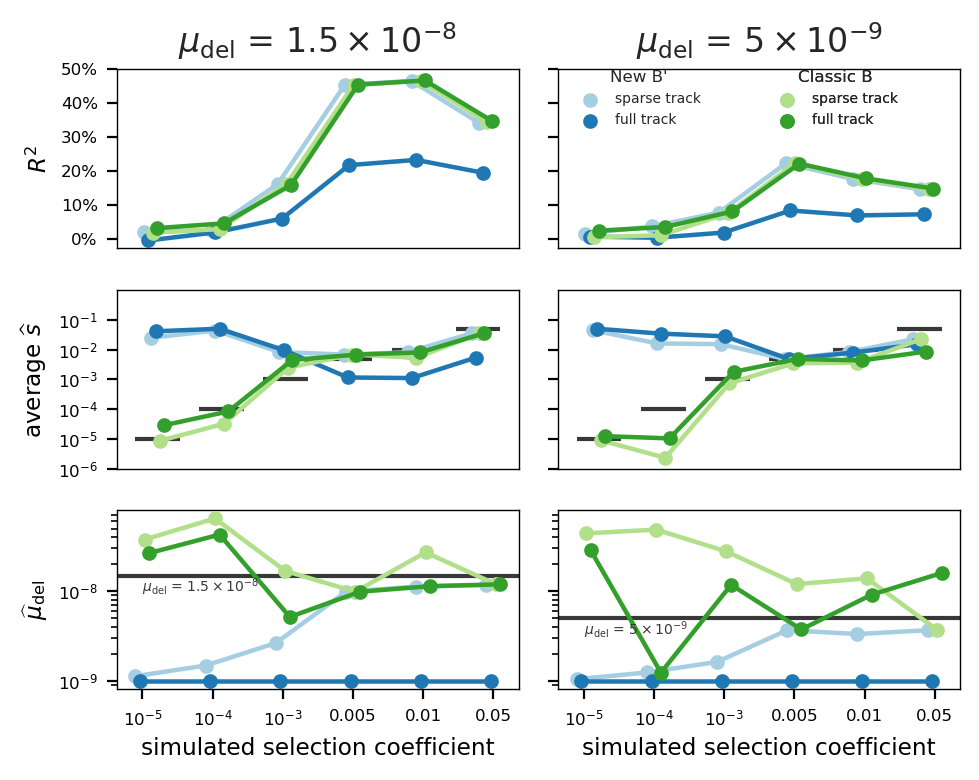

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharey='row', figsize=(5, 4), layout='constrained')

# Define common variables
order = ['sparse track, classic B, 1.004',
         'full track, classic B, 1.004',
         "sparse track, new B', 1.004",
         "full track, new B', 1.004"]
color_palette = sns.color_palette("Paired", len(order))
xx = np.arange(6)
xtick_labels = ["$10^{-5}$", "$10^{-4}$", "$10^{-3}$", "0.005", "0.01", "0.05"]
for col, mu_value, y_label in zip(range(2), [1.5e-8, 0.5e-8], ['1.5e-8', '0.5e-8']):
    df = d.loc[(np.abs(d['exp_rate'] - 1.004) < 1e-6) & (d['mu'] == mu_value) & (d['sh'] > 1e-8) & (d['h'] == 0.5)].sort_values(['type', 'model'])

    # Loop through rows
    for row, plot_y, ylabel in zip(range(3), ['R2', 'log10_est_mean_sh', 'est_mu'], ['$R^2$', 'average $\widehat{s}$', '$\widehat{\mu}_\mathrm{del}$']):
        fax = ax[row, col]
        sns.pointplot(x='sh', y=plot_y, data=df, hue='type', ax=fax, hue_order=order, errorbar=None, scale=0.6,
                      dodge=0.2, palette=color_palette)
        fax.legend_.remove()
        mulab = latex_scientific_notation(mu_value)
        if row == 0:
            r2_ticks = np.arange(0, 0.51, 0.1)
            fax.set_yticks(r2_ticks)
            fax.set_yticklabels([f'{tick * 100:.0f}%' for tick in r2_ticks], fontsize=6)
            fax.set_title(f"$\mu_\mathrm{{del}}$ = {mulab}")
        elif row == 1:
            ylabs = np.array([-6, -5, -4, -3, -2, -1 ])
            fax.set_yticks(ylabs)
            fax.set_yticklabels([f'$10^{{{tick}}}$' for tick in ylabs], fontsize=6)
            true_sh = [np.log10(float(x.get_text())) for x in fax.get_xticklabels()]
            x_positions = np.arange(len(true_sh))
            fax.hlines(true_sh, x_positions - 0.35, x_positions + 0.35, color='0.22', linewidth=1.5, zorder=-1)
            fax.set_ylim(None, 0.001)
        elif row == 2:
            fax.axhline(mu_value, c='0.22', linestyle='solid', linewidth=1.5, zorder=-1)
            fax.annotate(f"$\mu_\mathrm{{del}}$ = {mulab}", (0, 0.66*mu_value), fontsize=5, c='0.22', ha='left', zorder=10)
            fax.semilogy() 
            fax.tick_params(labelsize=6)
            
        if row != 2:
            fax.set_xticks([])
            fax.set_xticklabels([])
            fax.set_xlabel('')
        else:
            fax.set_xticks(xx)
            fax.set_xticklabels(xtick_labels,  fontsize=6)
            fax.set_xlabel('simulated selection coefficient')

        if col == 1:
            ylabel = ''
    
        fax.set_ylabel(ylabel)
        
lax = ax[0, 1]
old_legend = lax.legend()
lax.legend_.remove()

# Get the legend components
legend_handles = old_legend.legendHandles
legend_labels = [t.get_text().split(',')[0] for t in old_legend.get_texts()]

# Split the components into two lists
midpoint = len(legend_handles) // 2
legend_handles_1 = legend_handles[:midpoint]
legend_labels_1 = legend_labels[:midpoint]
legend_handles_2 = legend_handles[midpoint:]
legend_labels_2 = legend_labels[midpoint:]

# Create two separate legends using the lists
font_kwargs = dict(fontsize=5, title_fontsize=6)
legend_1 = lax.legend(legend_handles_1, legend_labels_1, loc=(0.01, 0.6), title="New B'", **font_kwargs)
legend_2 = lax.legend(legend_handles_2, legend_labels_2, loc=(0.5, 0.6),  title="Classic B", **font_kwargs)
lax.add_artist(legend_1)
lax.add_artist(legend_2)
# Add the legends to the plot
#fig.legend(loc=(0.9, 0.5), handles=legend_handles_1, labels=legend_labels_1, fontsize=5, title='New B\'', title_fontsize=7)
#fig.legend(loc=(0.9, 0.6), handles=legend_handles_2, labels=legend_labels_2, fontsize=5, title="Classic B", title_fontsize=7)


plt.tight_layout()
plt.savefig('../manuscript/figures/supplementary/subfigure_sim_mle_expansion.pdf', bbox_inches='tight')

### Recessive Deleterious Mutations

/tmp/ipykernel_17974/3626480947.py:59: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = old_legend.legendHandles
/tmp/ipykernel_17974/3626480947.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


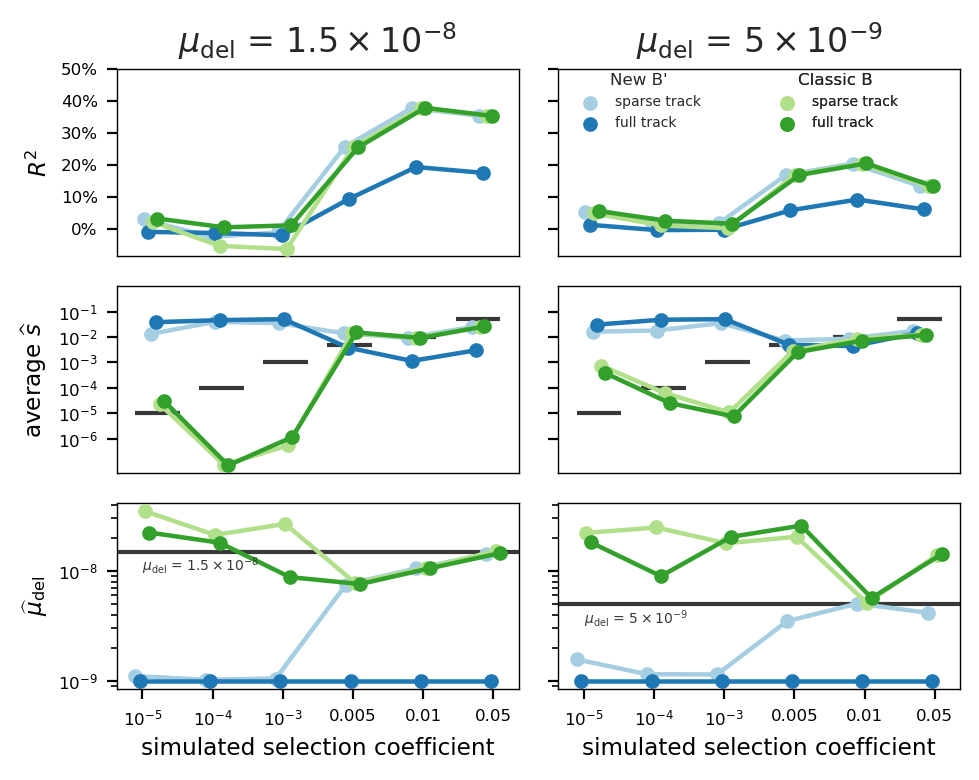

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharey='row', figsize=(5, 4), layout='constrained')

# Define common variables
order = ['sparse track, classic B, False',
         'full track, classic B, False',
         "sparse track, new B', False",
         "full track, new B', False"]
color_palette = sns.color_palette("Paired", len(order))
xx = np.arange(6)
xtick_labels = ["$10^{-5}$", "$10^{-4}$", "$10^{-3}$", "0.005", "0.01", "0.05"]
for col, mu_value, y_label in zip(range(2), [1.5e-8, 0.5e-8], ['1.5e-8', '0.5e-8']):
    df = d.loc[(d['exp_rate'] == False) & (d['mu'] == mu_value) & (d['sh'] > 1e-8) & (d['h'] == 0.3)].sort_values(['type', 'model'])

    # Loop through rows
    for row, plot_y, ylabel in zip(range(3), ['R2', 'log10_est_mean_sh', 'est_mu'], ['$R^2$', 'average $\widehat{s}$', '$\widehat{\mu}_\mathrm{del}$']):
        fax = ax[row, col]
        sns.pointplot(x='sh', y=plot_y, data=df, hue='type', ax=fax, hue_order=order, errorbar=None, scale=0.6,
                      dodge=0.2, palette=color_palette)
        fax.legend_.remove()
        mulab = latex_scientific_notation(mu_value)
        if row == 0:
            r2_ticks = np.arange(0, 0.51, 0.1)
            fax.set_yticks(r2_ticks)
            fax.set_yticklabels([f'{tick * 100:.0f}%' for tick in r2_ticks], fontsize=6)
            fax.set_title(f"$\mu_\mathrm{{del}}$ = {mulab}")
        elif row == 1:
            ylabs = np.array([-6, -5, -4, -3, -2, -1 ])
            fax.set_yticks(ylabs)
            fax.set_yticklabels([f'$10^{{{tick}}}$' for tick in ylabs], fontsize=6)
            true_sh = [np.log10(float(x.get_text())) for x in fax.get_xticklabels()]
            x_positions = np.arange(len(true_sh))
            fax.hlines(true_sh, x_positions - 0.35, x_positions + 0.35, color='0.22', linewidth=1.5, zorder=-1)
            fax.set_ylim(None, 0.001)
        elif row == 2:
            fax.axhline(mu_value, c='0.22', linestyle='solid', linewidth=1.5, zorder=-1)
            fax.annotate(f"$\mu_\mathrm{{del}}$ = {mulab}", (0, 0.66*mu_value), fontsize=5, c='0.22', ha='left', zorder=10)
            fax.semilogy() 
            fax.tick_params(labelsize=6)
            
        if row != 2:
            fax.set_xticks([])
            fax.set_xticklabels([])
            fax.set_xlabel('')
        else:
            fax.set_xticks(xx)
            fax.set_xticklabels(xtick_labels,  fontsize=6)
            fax.set_xlabel('simulated selection coefficient')

        if col == 1:
            ylabel = ''
    
        fax.set_ylabel(ylabel)
        
lax = ax[0, 1]
old_legend = lax.legend()
lax.legend_.remove()

# Get the legend components
legend_handles = old_legend.legendHandles
legend_labels = [t.get_text().split(',')[0] for t in old_legend.get_texts()]

# Split the components into two lists
midpoint = len(legend_handles) // 2
legend_handles_1 = legend_handles[:midpoint]
legend_labels_1 = legend_labels[:midpoint]
legend_handles_2 = legend_handles[midpoint:]
legend_labels_2 = legend_labels[midpoint:]

# Create two separate legends using the lists
font_kwargs = dict(fontsize=5, title_fontsize=6)
legend_1 = lax.legend(legend_handles_1, legend_labels_1, loc=(0.01, 0.6), title="New B'", **font_kwargs)
legend_2 = lax.legend(legend_handles_2, legend_labels_2, loc=(0.5, 0.6),  title="Classic B", **font_kwargs)
lax.add_artist(legend_1)
lax.add_artist(legend_2)
# Add the legends to the plot
#fig.legend(loc=(0.9, 0.5), handles=legend_handles_1, labels=legend_labels_1, fontsize=5, title='New B\'', title_fontsize=7)
#fig.legend(loc=(0.9, 0.6), handles=legend_handles_2, labels=legend_labels_2, fontsize=5, title="Classic B", title_fontsize=7)


plt.tight_layout()
plt.savefig('../manuscript/figures/supplementary/subfigure_sim_mle_recessive.pdf', bbox_inches='tight')